In [1]:
#general operations
import time
import os
import copy
from __future__ import print_function, division

#for openning images via an URL
from PIL import Image
import requests
from io import BytesIO
from skimage import io, transform

#data processing
import pandas as pd
import numpy as np

#data visualisation
import matplotlib.pyplot as plt

#standard AWS operations
from sagemaker import get_execution_role
import boto3

#ML tools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.dataset import Dataset
import torchvision
from torchvision import models, transforms

In [2]:
#progress bar
from tqdm import tqdm
tqdm.pandas()

In [3]:
%matplotlib inline

In [4]:
role = get_execution_role()
bucket = 'see-ml-storage'

##### Data Preview / Setup

In [12]:
from pathlib import Path
s3_path =  Path('s3://see-ml-storage')
assert s3_path.exists()

AssertionError: 

In [10]:
csv_path='s3://{}/case3_dataset_v3.csv'.format(bucket)
csv_path = Path(csv_path)
assert csv_path.exists()

AssertionError: 

In [11]:
df=pd.read_csv(csv_path)

FileNotFoundError: /see-ml-storage/case3_dataset_v3.csv

In [12]:
df.drop(['Unnamed: 0', 'Unnamed: 0.1'],axis=1,inplace=True)
df=df[['IMAGE_URL','ATTR_COM']].copy()
df.columns=['path','label']
#df=df[['IMAGE_URL','ATTR_COM','PRODUCT_ID']].copy()
#df.columns=['path','label','id']

In [13]:
df.head()

,path,label
0,http://i03.hktdc-img.com/rsc?profile=productim...,Material_Cotton
1,http://i03.hktdc-img.com/rsc?profile=productim...,Material_Cotton
2,http://i03.hktdc-img.com/rsc?profile=productim...,Material_Cotton
3,http://i03.hktdc-img.com/rsc?profile=productim...,Material_Cotton
4,http://i03.hktdc-img.com/rsc?profile=productim...,Material_Cotton


In [9]:
#df['path']=df['id'].apply(str) + '.jpg'

In [10]:
#what is happening here is weird
#the situation is that somehow previously the data is uploaded
#in a very awkward way, so it is needed to do some mapping.
#anotherbucket='hktdc-pec-emp2.0-product-photos'
#s3=boto3.client('s3')

In [11]:
'''

def get_bucket_keys(bucket_name):
    """Get a list of all keys in an S3 bucket."""
    keys = []

    kwargs = {'Bucket': bucket_name}
    while True:
        resp = s3.list_objects_v2(**kwargs)
        for obj in resp['Contents']:
            keys.append(obj['Key'])

        try:
            kwargs['ContinuationToken'] = resp['NextContinuationToken']
        except KeyError:
            break

    return keys

item_list=get_bucket_keys(anotherbucket)

'''

In [18]:
"""

def func(x):
    for img_path in item_list:
        file_name=img_path.split('\\')[-1]
        if x == file_name:
            return img_path
    return np.nan
    
df['path_aws']=df['path'].progress_apply(func)  
    
df.head()
dfcopy=df.copy()
df=df[['path_aws','label']]

drop_index=df[df['path_aws'].apply(str)=='nan'].index
df=df.drop(drop_index, axis=0)

"""

In [14]:
mapping_list = list(df.label.unique())
mapping = {label: key for key, label in enumerate(mapping_list)}

In [15]:
mapping

{'Material_Cotton': 0,
 'Material_Plastic': 1,
 'Material_Paper': 2,
 'Material_Polyester': 3,
 'Material_Metal': 4,
 'Material_Nylon': 5,
 'Material_Wood': 6,
 'Material_Leather': 7,
 'Material_Knitted': 8,
 'Material_Acrylic': 9,
 'Gender_Unisex': 10,
 'Gender_Men': 11,
 'Gender_Women': 12}

In [16]:
df.label=df.label.map(mapping)

In [17]:
df=df.reindex(np.random.permutation(df.index))

In [18]:
df.shape

(160108, 2)

In [19]:
val_samples_num=(int(df.shape[0]*0.1))
val = df.iloc[:val_samples_num]
train = df.iloc[val_samples_num:]


val_sample=val.sample(500)
train_sample =train.sample(10000)

In [20]:
#save data locally?! how does this really works. no idea.
train.to_csv('train.csv', header=False, index=False)
val.to_csv('validation.csv', header=False, index=False)

#example
prefix = 'outsource_labels'

#save data back into AWS S3
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

train_sample.to_csv('train_sample.csv', header=False, index=False)
val_sample.to_csv('validation_sample.csv', header=False, index=False)

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train_sample.csv')).upload_file('train_sample.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation_sample.csv')).upload_file('validation_sample.csv')


In [ ]:
#example of opening the files
df=pd.read_csv('s3://{}/{}/train/train.csv'.format(bucket,prefix),header=None)

In [12]:
time.time()

1552015447.3270092

##### Customising our own Dataset Object

In [5]:
#creating our own customised data
class empDataset(Dataset):
    def __init__(self, csv_file, transforms=None):
        self.raw_data = pd.read_csv(csv_file, header=None)
        self.transforms = transforms
        self.labels_arr = self.raw_data.iloc[:,1]
        self.image_arr = self.raw_data.iloc[:,0]
        self.data_len = len(self.raw_data.index)
    
    def __getitem__(self, index):
        #obtaining the image data from URL
        #since=time.time()
        img_response = requests.get(self.image_arr[index])
        one_img = Image.open(BytesIO(img_response.content))
        #img_path=os.path.join('s3://{}'.format(anotherbucket),self.image_arr[index])
        #print(img_path)
        #one_img = io.imread(one_img)
        #print('Image download time: {}s'.format(time.time()-since))
        
        if self.transforms is not None:
            transformed_img = self.transforms(one_img)
        else:
            transformations = transforms.Compose([transforms.ToTensor()])
            transformed_img = transformations(one_img)
        
        # Get the image Label
        single_image_label = self.labels_arr[index]
        
        return (transformed_img, single_image_label)
    
    def __len__(self):
        return self.data_len

In [6]:
#setting up the image transformation
transformations = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
prefix = 'outsource_labels'
csv_path='s3://{}/{}/train/train_sample.csv'.format(bucket,prefix)

In [8]:
keys=['train','validation']
emp_datasets = {key: empDataset('s3://{}/{}/{}/{}.csv'.format(bucket,prefix,key,key), transforms=transformations) for key in keys}
datasets_loader = {key: torch.utils.data.DataLoader(dataset=emp_datasets[key],
                                                batch_size=4,
                                                shuffle=False,
                                                num_workers=4) for key in keys}

In [9]:
#emp_dataset = empDataset(csv_file=csv_path, transforms=transformations)
#my_dataset_loader = torch.utils.data.DataLoader(dataset=emp_dataset,batch_size=4,shuffle=False,num_workers=4)
#classes_arr = emp_dataset.labels_arr

In [10]:
classes_arr = emp_datasets['train'].labels_arr

quick test on how the dataloader is working by visualising some data

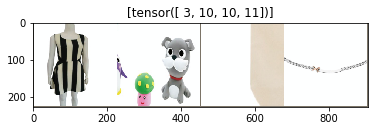

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(datasets_loader['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[classes])

##### Setting up the Cloud Machine for Machine Learning

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
torch.cuda.is_available()

False

##### Setting up the Model
Let's do a transfer learning using 

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in datasets_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [15]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [16]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 13)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


In [ ]:
print('Process Done')

In [ ]:
visualize_model(model_ft)

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [ ]:
#just to play safe - saving the models in both methods
#save the model parameters only
torch.save(model_conv.state_dict(), PATH)
# save the entire model (but can have future issues)
torch.save(model_conv, PATH)